<a href="https://colab.research.google.com/github/umansky81/TMDB/blob/main/TMDB_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Main Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

### Load Final Raw CSV File

In [ ]:
# List of all chunk paths (adjust if needed)
paths = [
    "/content/drive/MyDrive/Colab Notebooks/ML/ML Project 2 (Orit)/CSV Files/Split CSV/part_1.csv",
    "/content/drive/MyDrive/Colab Notebooks/ML/ML Project 2 (Orit)/CSV Files/Split CSV/part_2.csv",
    "/content/drive/MyDrive/Colab Notebooks/ML/ML Project 2 (Orit)/CSV Files/Split CSV/part_3.csv",
    "/content/drive/MyDrive/Colab Notebooks/ML/ML Project 2 (Orit)/CSV Files/Split CSV/part_4.csv",
    "/content/drive/MyDrive/Colab Notebooks/ML/ML Project 2 (Orit)/CSV Files/Split CSV/part_5.csv",
    "/content/drive/MyDrive/Colab Notebooks/ML/ML Project 2 (Orit)/CSV Files/Split CSV/part_6.csv",
]

# Load and concatenate
df_raw_final = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)

In [ ]:
df_raw_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164705 entries, 0 to 164704
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    164705 non-null  int64  
 1   popularity            164705 non-null  float64
 2   name                  164700 non-null  object 
 3   number_of_seasons     164705 non-null  int64  
 4   number_of_episodes    164705 non-null  int64  
 5   original_language     164705 non-null  object 
 6   vote_count            164705 non-null  int64  
 7   vote_average          164705 non-null  float64
 8   overview              97620 non-null   object 
 9   adult                 164705 non-null  bool   
 10  backdrop_path         76382 non-null   object 
 11  first_air_date        133809 non-null  object 
 12  last_air_date         135768 non-null  object 
 13  homepage              50419 non-null   object 
 14  in_production         164705 non-null  bool   
 15  

### Remove Redundant Columns

In [ ]:
# remove redundanct columns and save as a new df to be worked on from now on
# url-type columns (backdrop path, homepage) are not useful in any way and they have too many NaN's
# 'spoken_languages' data is already available in the 'languages' column and needs to be translated
# 'original_name' data is already available in the 'name' column and needs to be translated
# 'created by' has mostly NaN's
# 'tagline' has mostly NaN's
# 'production companies' has mostly NaN's
# 'production countries' has mostly NaN's, and we already have country based profiling from the 'origin country' column

df = df_raw_final.drop(columns=['backdrop_path','homepage','poster_path','spoken_languages','created_by','production_companies','production_countries','original_name','tagline'])

### Convert Object Columns to String Type

In [ ]:
# Specify columns to be converted from 'object' to 'string' type
convert_to_string = ['name','overview','networks']

# Convert specified columns to string type and create string_df
string_df = df[convert_to_string].astype('string')

# Remove punctuation
for col in convert_to_string:
    string_df[col] = string_df[col].str.translate(str.maketrans('', '', string.punctuation))

# Assign the cleaned columns back to the original DataFrame
df[convert_to_string] = string_df

### Convert Boolean Columns to INT Type

In [ ]:
# Specify columns to be converted from 'boolean' to 'INT' type
convert_to_int = ['adult','in_production']

# convert columns to INT type
df[convert_to_int] = df[convert_to_int].astype(int)

### Convert Object Columns to Date Type

In [ ]:
# Specify columns to be converted from 'object' to 'date' type
convert_to_date = ['first_air_date','last_air_date']

# convert columns to datetime type
df[convert_to_date] = df[convert_to_date].apply(pd.to_datetime)

### Convert Object Columns to Categorical Type

In [ ]:
# Specify columns to be converted from 'object' to 'category' type
convert_to_cat = ['original_language','type','status','genres','origin_country']

# Convert columns to category type
df[convert_to_cat] = df[convert_to_cat].astype('category')

### Handle the 'Genres' Categories



*   First, need to consolidate the genre list to a shorter and more generic list of categories
*   Second, because we still have lots of NaNs, I will try to infere the genres from the 'overview' column using keyword search



In [ ]:
# Mapping from original genres to consolidated categories
genre_map = {
    'Drama': 'drama',
    'Soap': 'drama',
    'Romance': 'drama',
    'Comedy': 'comedy',
    'Talk': 'comedy',
    'Talk-Show': 'comedy',
    'Documentary': 'documentary',
    'Biography': 'documentary',
    'Animation': 'animation',
    'Kids': 'animation',
    'Action & Adventure': 'action_adventure',
    'Action': 'action_adventure',
    'Crime': 'action_adventure',
    'Mystery': 'action_adventure',
    'Thriller': 'action_adventure',
    'Adventure': 'action_adventure',
    'Sci-Fi & Fantasy': 'action_adventure',
    'Fantasy': 'action_adventure',
    'Sci-Fi': 'action_adventure',
    'War': 'action_adventure',
    'Reality': 'reality',
    'Reality-TV': 'reality',
    'Game-Show': 'reality',
    'Family': 'other',
    'War & Politics': 'other',
    'News': 'other',
    'Western': 'other',
    'Music': 'other',
    'Musical': 'other',
    'History': 'other',
    'Sport': 'other',
    'Short': 'other',
    'Adult': 'other',
    'Horror': 'other',
    '\\N': 'other'
}

# Broader keyword dictionary for overview-based inference
keyword_map = {
    'drama': ['drama', 'romantic', 'romance', 'relationship', 'soap'],
    'comedy': ['comedy', 'funny', 'humor', 'sitcom', 'parody', 'joke', 'hilarious'],
    'documentary': ['documentary', 'biography', 'true story', 'real life', 'docu'],
    'animation': ['animation', 'animated', 'cartoon', 'kids', 'pixar'],
    'action_adventure': [
        'action', 'fight', 'battle', 'war', 'thriller', 'crime',
        'mystery', 'detective', 'spy', 'adventure', 'fantasy',
        'sci-fi', 'space', 'galaxy', 'superhero', 'magic'
    ],
    'reality': ['reality', 'contest', 'competition', 'game show', 'talent', 'survivor'],
    'other': [
        'family', 'politics', 'news', 'music', 'musical', 'history',
        'western', 'sport', 'short', 'adult', 'horror'
    ]
}

def consolidate_genres(genre_list, overview=""):

    # Case 1: Genres exist → consolidate directly
    if isinstance(genre_list, list) and genre_list and genre_list != ['\\N']:
        consolidated = set()
        for genre in genre_list:
            consolidated.add(genre_map.get(genre.strip(), 'other'))
        return list(consolidated)

    # Case 2: Genres missing → infer from overview (fuzzy substring search)
    overview_lower = str(overview).lower()
    inferred = set()
    for cat, keywords in keyword_map.items():
        for kw in keywords:
            if kw in overview_lower:
                inferred.add(cat)

    return list(inferred) if inferred else ['other']

# Apply on dataframe
df['genre_list'] = df['genres'].str.split(', ')
df['genre_group'] = df.apply(
    lambda row: consolidate_genres(row['genre_list'], row['overview']),
    axis=1
)

# Remove 'other' if there are other categories present
def clean_other(genres):
    if 'other' in genres and len(genres) > 1:
        return [g for g in genres if g != 'other']
    return genres

df['genre_group'] = df['genre_group'].apply(clean_other)

# Drop helper columns
df.drop(columns=['genres', 'genre_list'], inplace=True)

### Handle the 'Origin Country' Column

In [ ]:
# I will re-categorize the country list to a more generic region list
country_map = {
    'US': 'north_america',
    'CA': 'north_america',
    'GB': 'europe',
    'DE': 'europe',
    'FR': 'europe',
    'NL': 'europe',
    'DK': 'europe',
    'SE': 'europe',
    'IT': 'europe',
    'ES': 'europe',
    'RU': 'eastern_europe',
    'PL': 'eastern_europe',
    'TR': 'middle_east',
    'IN': 'south_asia',
    'PH': 'southeast_asia',
    'TH': 'southeast_asia',
    'JP': 'east_asia',
    'CN': 'east_asia',
    'KR': 'east_asia',
    'HK': 'east_asia',
    'TW': 'east_asia',
    'AU': 'oceania',
    'BR': 'south_america',
    '\\N': 'other'
}

def consolidate_countries(country_list):
    if not isinstance(country_list, list):
        return ['other']

    consolidated = set()
    for country in country_list:
        consolidated.add(country_map.get(country.strip(), 'other'))
    return list(consolidated)

# Split the 'origin_country' column by comma
df['country_list'] = df['origin_country'].str.split(', ')
df['country_group'] = df['country_list'].apply(consolidate_countries)

# Drop helper columns
df.drop(columns=['country_list'], inplace=True)

### Handle The 'Original Language' Category



*   The original language list contains over 100 entries, I will consolidate it to a more generic list, based on the top counted languages values, and the rest will be classified as 'other'. Later on, I will use 'one-hot' encoding on the consolidated list



In [ ]:
# Mapping dictionary: language code -> category
original_language_map = {
    'en': 'english',
    'zh': 'east_asian',
    'cn': 'east_asian',
    'ja': 'east_asian',
    'ko': 'east_asian',
    'de': 'western_european',
    'fr': 'western_european',
    'nl': 'western_european',
    'da': 'western_european',
    'sv': 'western_european',
    'no': 'western_european',
    'es': 'romance',
    'pt': 'romance',
    'it': 'romance',
    'ru': 'slavic',
    'cs': 'slavic',
    'pl': 'slavic',
    'ar': 'middle_eastern',
    'tr': 'middle_eastern',
    'hi': 'south_asian',
    'th': 'southeast_asian'
}

# Apply mapping with default "Other" for unknown codes
df['language_group'] = df['original_language'].apply(lambda x: original_language_map.get(x, 'other'))

# Drop original column
df.drop(columns=['original_language'], inplace=True)

### Handle The 'Type' Category

In [ ]:
# Consolidate the 'Type' category to a more convinient and short list
# Mapping dictionary: type -> category
type_map = {
    'Scripted': 'scripted',
    'Documentary': 'documentary',
    'Miniseries': 'miniseries'
}

# Apply mapping with default "Other" for unknown codes
df['type_group'] = df['type'].apply(lambda x: type_map.get(x, 'other'))

# Drop original column
df.drop(columns=['type'], inplace=True)

# EDA

### Data Protocol

In [ ]:
# Output files path
output_path = "/content/drive/MyDrive/Colab Notebooks/ML/ML Project 2 (Orit)/Data Protocol"

# Select numeric categories only for data protocol files
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Type of values
df.dtypes.to_excel(output_path + "/tvshows_types.xlsx",sheet_name='data_type')

# Maximum values
df_numeric.max().to_excel(output_path + "/tvshows_max.xlsx",sheet_name='max')

# Minimum Values
df_numeric.min().to_excel(output_path + "/tvshows_min.xlsx",sheet_name='min')

# Missing Values
df.isnull().sum(axis=0).to_excel(output_path + "/tvshows_NA.xlsx", sheet_name='NA')

# Exporting results to the protocol
df_numeric.nunique().to_excel(output_path + "/tvshows_unique.xlsx",sheet_name='unique')


### Plot a General Distribution of the Target- Popularity (Using a Log Scale)

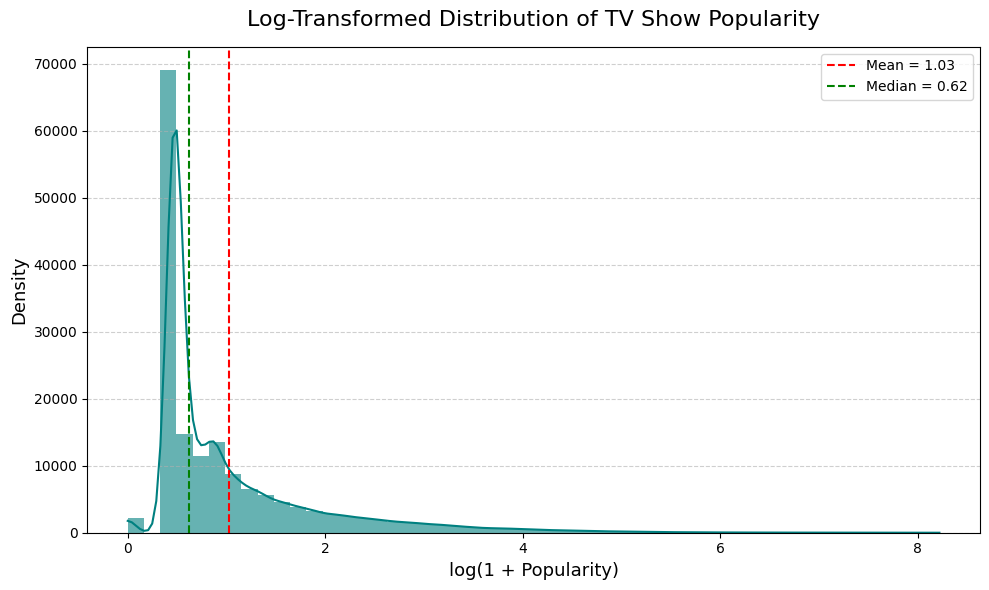

In [ ]:
# Compute log-transformed popularity
df['popularity_log'] = np.log1p(df['popularity'])  # log(1 + x) handles zeros safely

plt.figure(figsize=(10, 6))

sns.histplot(
    df['popularity_log'],
    bins=50,
    kde=True,
    color='teal',
    alpha=0.6,
    edgecolor=None
)

# Add mean and median lines
plt.axvline(df['popularity_log'].mean(), color='red', linestyle='--', linewidth=1.5, label=f"Mean = {df['popularity_log'].mean():.2f}")
plt.axvline(df['popularity_log'].median(), color='green', linestyle='--', linewidth=1.5, label=f"Median = {df['popularity_log'].median():.2f}")

# Titles and styling
plt.title('Log-Transformed Distribution of TV Show Popularity', fontsize=16, pad=15)
plt.xlabel('log(1 + Popularity)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()



*   It is apparent that the target value, popularity, is not normally distributed and is extremely skewed
*   A log scale was necessary in order to be able to see any kind of trend



### Plot Distribution Chart for Binary Features

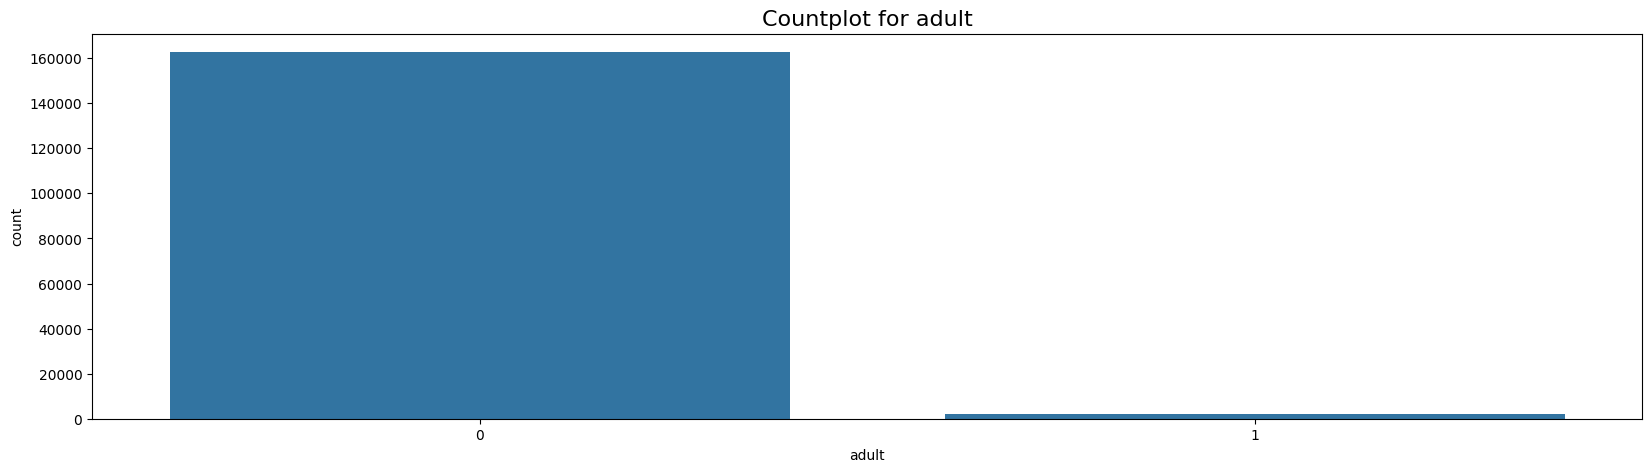

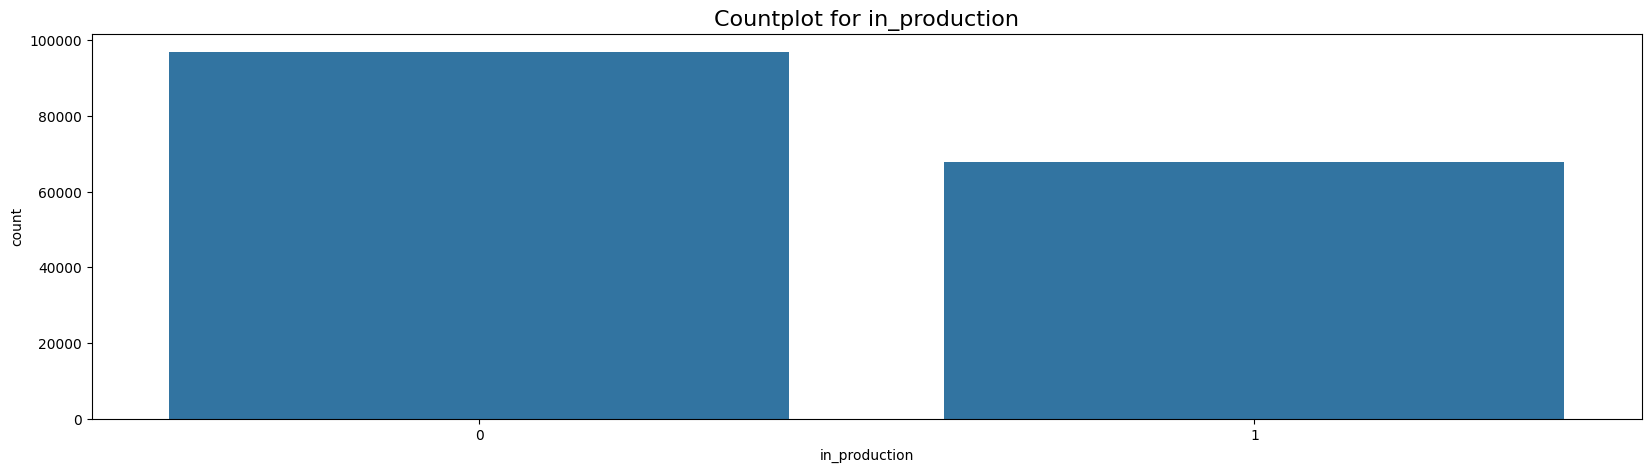

In [ ]:
binary_columns = ['adult', 'in_production']

for col in binary_columns:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(x=df[col].dropna(), data=df)
    ax.set_title(f'Countplot for {col}', fontsize=16)
    plt.show()

### Plot Distribution Chart for Categorical Features

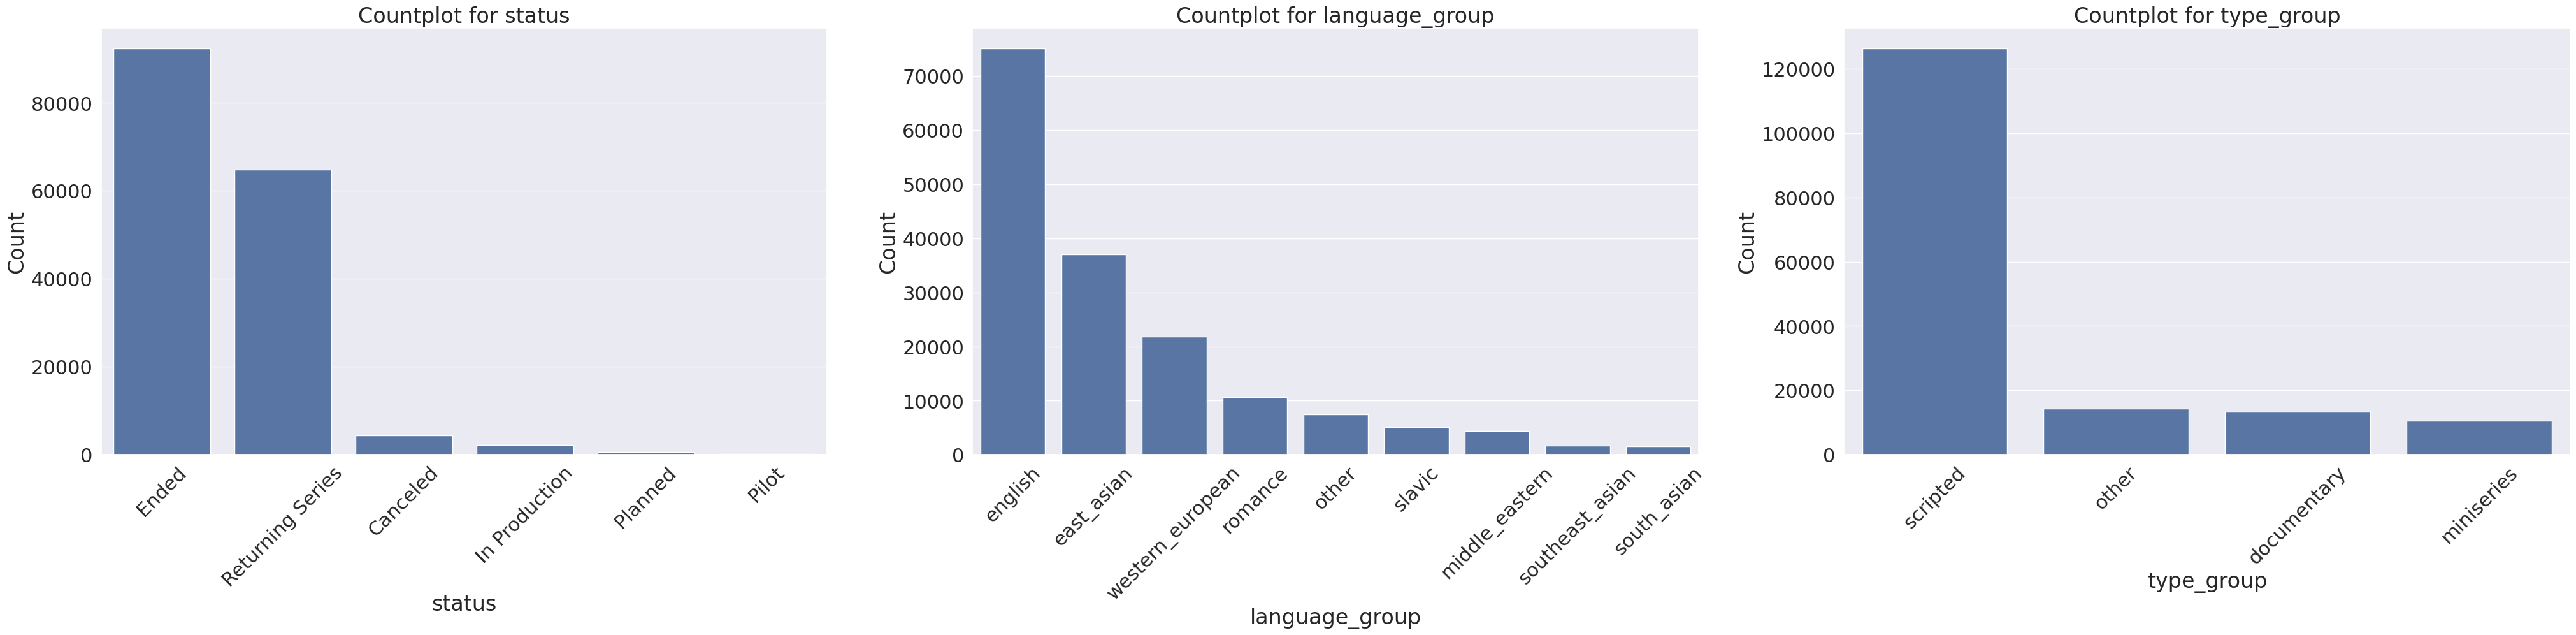

In [ ]:
# Define list of categorical fields and create a separate df for them
new_df = ['status', 'language_group', 'type_group']
df_cat = df[new_df]

# Plot settings
a = 3  # rows
b = 3  # columns
c = 1  # plot counter

fig = plt.figure(figsize=(50, 40))
plt.subplots_adjust(hspace=0.8)
sns.set(font_scale=2)

for col in df_cat:
    # Convert to string, split comma-separated values, flatten, and strip whitespace
    exploded = df_cat[col].dropna().astype(str).str.split(',').explode().str.strip()

    # Count values
    value_counts = exploded.value_counts()

    # Plot
    plt.subplot(a, b, c)
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Countplot for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    c += 1

plt.show()



*   A significant percent of the TV shows are English based. We will have to check the influence of this fact on popularity: how popular are non-English shows?
*   The same is true for scripted shows vs. other type of shows: are scripted shows more popular?



### Plot Heat Map Chart for Numerical Features

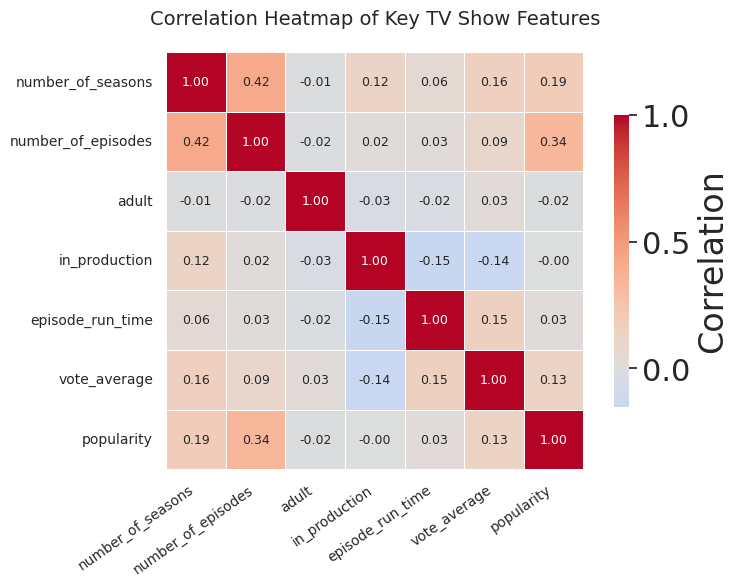

In [ ]:
features = [
    'number_of_seasons',
    'number_of_episodes',
    'adult',
    'in_production',
    'episode_run_time',
    'vote_average',
    'popularity'
]

# Compute correlation matrix
corr_matrix = df[features].corr(numeric_only=True)

# Create a clearer, more readable heatmap
plt.figure(figsize=(9, 7))  # larger figure for more space
sns.heatmap(
    corr_matrix,
    annot=True,           # show correlation numbers
    fmt=".2f",            # two decimals
    cmap='coolwarm',      # nice diverging color map
    center=0,
    square=True,
    linewidths=0.7,
    annot_kws={"size": 9},  # smaller text for annotations
    cbar_kws={"shrink": 0.7, "label": "Correlation"}
)

# Better styling
plt.title("Correlation Heatmap of Key TV Show Features", fontsize=14, pad=20)
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout(pad=2.0)
plt.show()


### Plot Scatter Charts for Popularity (Log Scale) vs. Selected Numerical Features

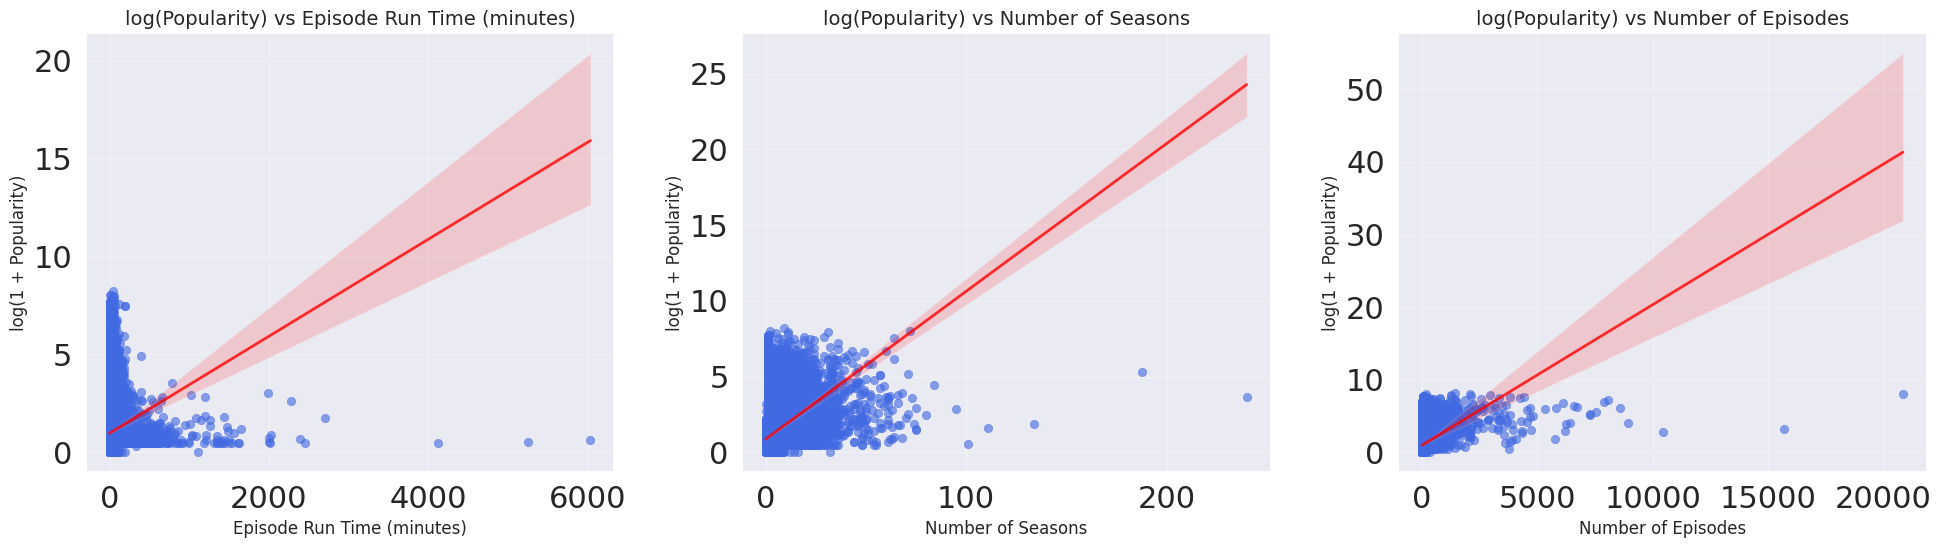

In [ ]:
# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# List of (x_column, title)
features = [
    ('episode_run_time', 'Episode Run Time (minutes)'),
    ('number_of_seasons', 'Number of Seasons'),
    ('number_of_episodes', 'Number of Episodes')
]

# Plot each scatter
for ax, (x_col, title) in zip(axes, features):
    sns.scatterplot(
        data=df,
        x=x_col,
        y='popularity_log',
        alpha=0.6,
        color='royalblue',
        edgecolor=None,
        ax=ax
    )

    # Add trendline
    sns.regplot(
        data=df,
        x=x_col,
        y='popularity_log',
        scatter=False,
        color='red',
        line_kws={"linewidth": 2, "alpha": 0.8},
        ax=ax
    )

    ax.set_title(f'log(Popularity) vs {title}', fontsize=14)
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel('log(1 + Popularity)', fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()




*   Unfortunately there is no apparent correlation between any of kind of numerical feature over another
*   I expect that most of the influence on a show's popularity will be derived from categorical features such as genre, language and type



### Plot Bar Charts for Average Popularity vs. Selected Features

/tmp/ipython-input-3947875230.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3947875230.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3947875230.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3947875230.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


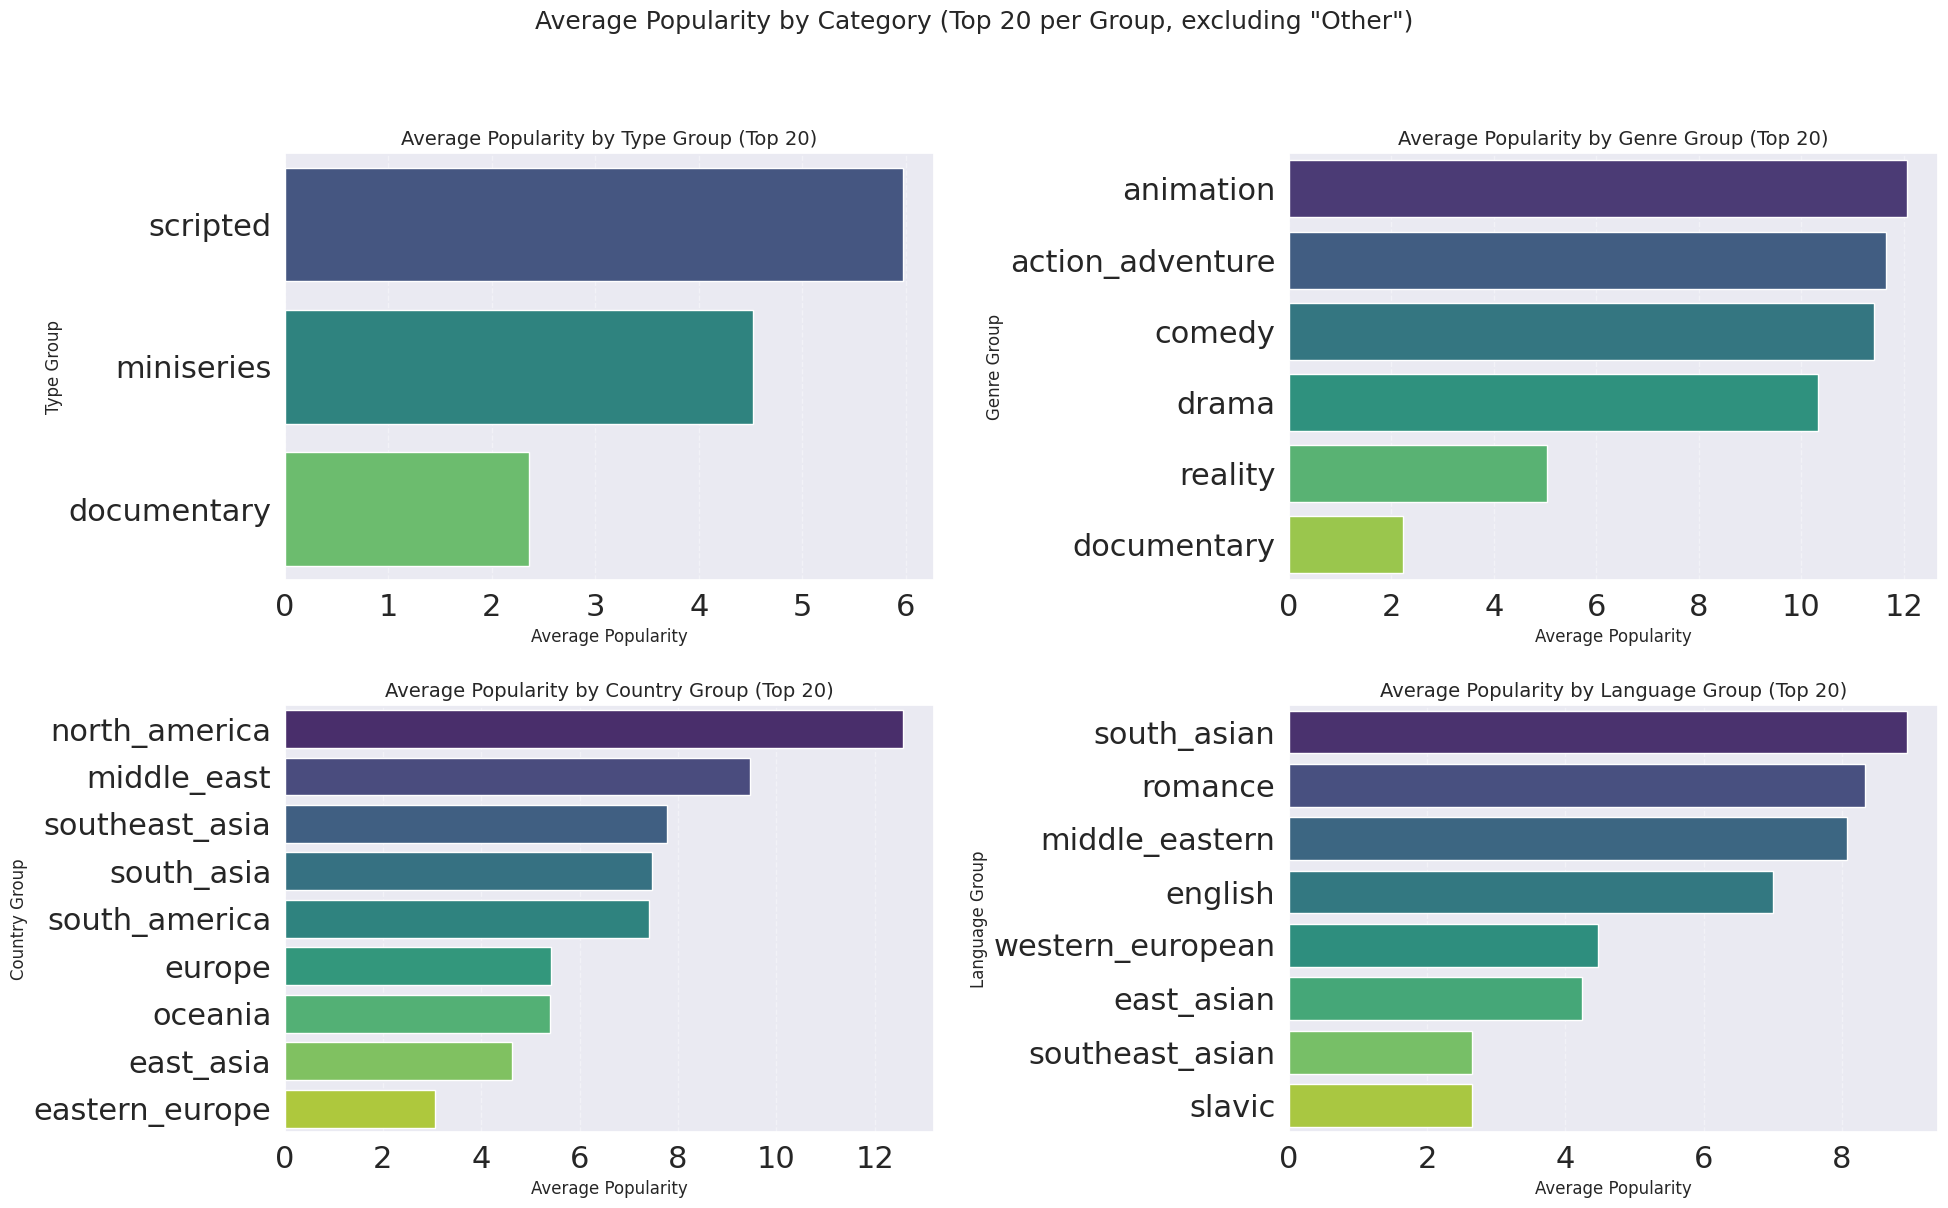

In [ ]:
# Define the grouping columns
group_columns = ['type_group', 'genre_group', 'country_group', 'language_group']

# Set up the figure
plt.figure(figsize=(20, 12))
plt.suptitle('Average Popularity by Category (Top 20 per Group, excluding "Other")', fontsize=18, y=1.02)

for i, col in enumerate(group_columns, 1):
    plt.subplot(2, 2, i)

    # Handle multi-label (list-type) columns like genre_group
    if df[col].apply(lambda x: isinstance(x, list)).any():
        exploded = df.explode(col)
        exploded = exploded[exploded[col].str.lower() != 'other']
        avg_popularity = (
            exploded.groupby(col)['popularity']
            .mean()
            .sort_values(ascending=False)
            .head(20)
        )
    else:
        filtered = df[df[col].str.lower() != 'other']
        avg_popularity = (
            filtered.groupby(col)['popularity']
            .mean()
            .sort_values(ascending=False)
            .head(20)
        )

    # Bar plot
    sns.barplot(
        x=avg_popularity.values,
        y=avg_popularity.index,
        palette='viridis'
    )

    plt.title(f"Average Popularity by {col.replace('_', ' ').title()} (Top 20)", fontsize=14)
    plt.xlabel('Average Popularity', fontsize=12)
    plt.ylabel(col.replace('_', ' ').title(), fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


### Skewness

In [ ]:
# Define list of continuous columns and create a separate df for them
con_cols= ['popularity','number_of_seasons','number_of_episodes','vote_count','vote_average','episode_run_time']
con_df = df[con_cols]

def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    #else
       # return default
pd.DataFrame(con_df.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

/tmp/ipython-input-3169248195.py:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pd.DataFrame(con_df.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)


,skewness
number_of_episodes,54.768914
vote_count,47.644759
popularity,36.348801
episode_run_time,34.953842
number_of_seasons,14.077769
vote_average,0.934211




*   The skewness test confirms that our target data is extremely skewed
*   It is possible that the skewness level will make it difficult to be able to predict the popularity with a regression model, therefore we will have to test as much regression methods as possible to be able to find a model that fits this data's behavior



In [ ]:
# Drop helper columns
df.drop(columns=['popularity_log'], inplace=True)

### T-Test: Popularity for English Language TV Shows vs. Non-English TV Shows

In [ ]:
import scipy.stats as stats

T-statistic: 9.285532773447256
P-value: 1.6276777748482057e-20


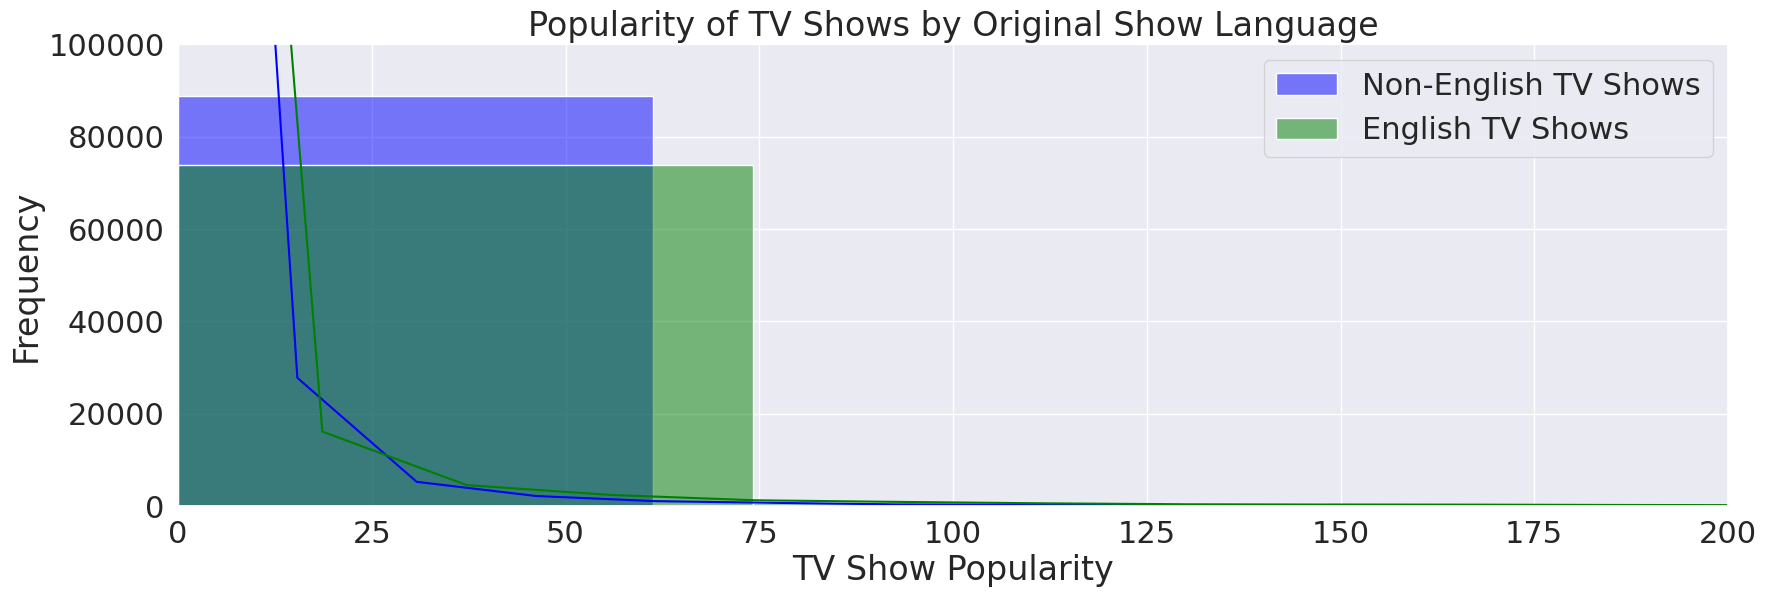

In [ ]:

#Separate the popularity data by English shows and non-English shows
non_english_shows = df[df['language_group'] != 'english']['popularity']
english_shows = df[df['language_group'] == 'english']['popularity']

# Perform an independent samples t-test
t_stat, p_value = stats.ttest_ind(english_shows, non_english_shows)

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Plotting the distribution of popularity between english and non-english tv shows
plt.figure(figsize=(20, 6))
sns.histplot(non_english_shows, bins=50, kde=True, color='blue', label='Non-English TV Shows', alpha=0.5)
sns.histplot(english_shows, bins=50, kde=True, color='green', label='English TV Shows', alpha=0.5)
plt.title('Popularity of TV Shows by Original Show Language')
plt.xlabel('TV Show Popularity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.ylim(0, 100000)
plt.xlim(0, 200)
plt.show()

### T-Test: Popularity for Shows With More Than One Season vs. Single-Season Shows

T-statistic: -54.653811346602
P-value: 0.0


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


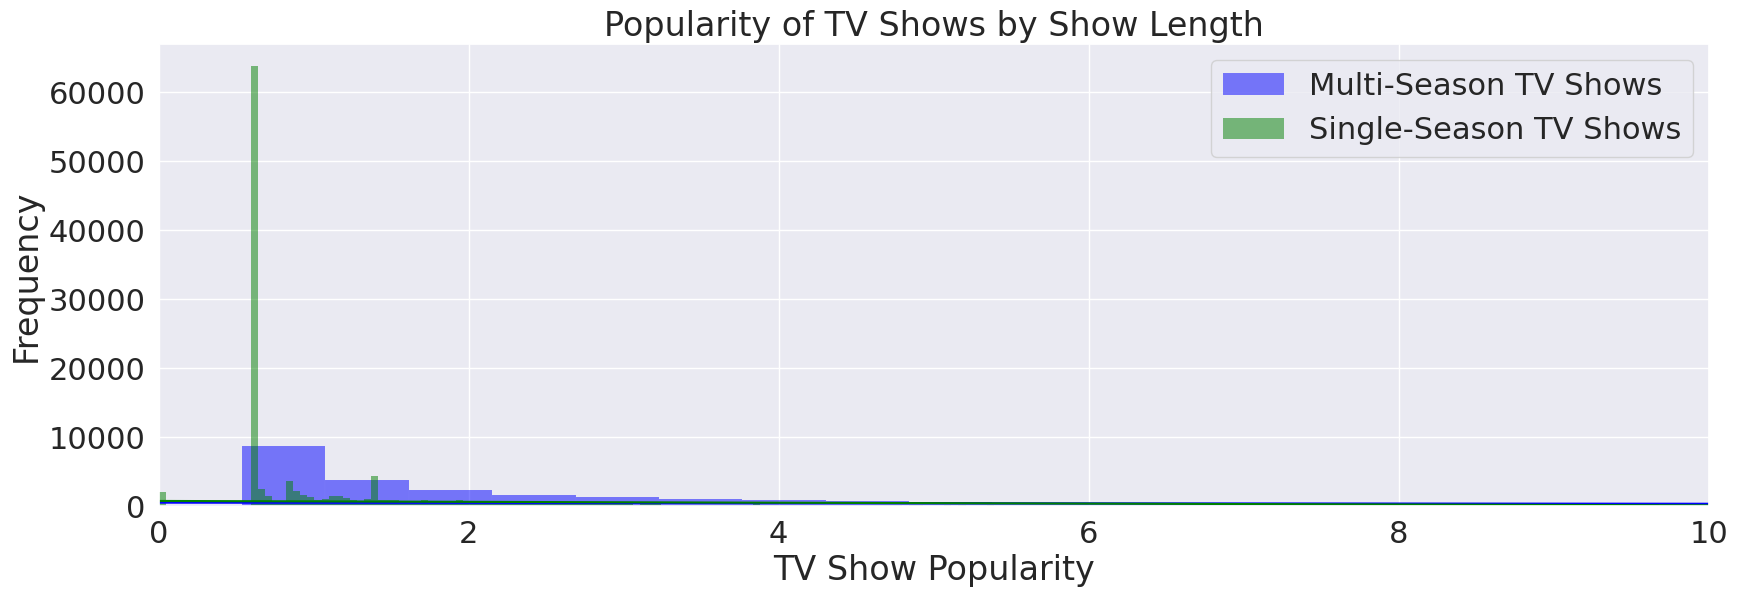

In [ ]:
#Separate the popularity data by single-season shows and multi-season shows
multi_season_shows = df[df['number_of_seasons'] > 1]['popularity']
single_season_shows = df[df['number_of_seasons'] <= 1]['popularity']

# Perform an independent samples t-test
t_stat, p_value = stats.ttest_ind(single_season_shows, multi_season_shows)

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Plotting the distribution of popularity between single-season and multi-season tv shows
plt.figure(figsize=(20, 6))
sns.histplot(multi_season_shows, kde=True, color='blue', label='Multi-Season TV Shows', alpha=0.5)
sns.histplot(single_season_shows, kde=True, color='green', label='Single-Season TV Shows', alpha=0.5)
plt.title('Popularity of TV Shows by Show Length')
plt.xlabel('TV Show Popularity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.show()

### ANOVA: Language Groups

In [ ]:
# Group 'popularity' values by each language group
groups = [group['popularity'].values for name, group in df.groupby('language_group')]

# Perform one-way ANOVA test
f_stat, p_value = stats.f_oneway(*groups)

# Print results
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# ANOVA interpretation
if p_value < 0.05:
    print("✅ The differences in average popularity between language groups are statistically significant.")
else:
    print("❌ No significant difference in average popularity between language groups.")


ANOVA F-statistic: 28.2947
P-value: 1.8786e-44
✅ The differences in average popularity between language groups are statistically significant.


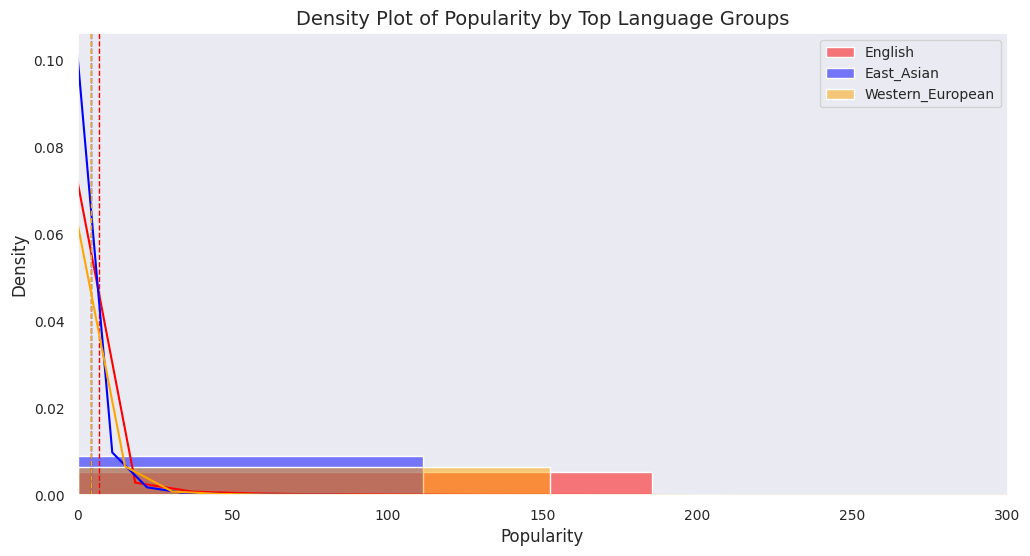

In [ ]:
# Get the top 3 most common language groups (to keep the plot readable)
top_langs = df['language_group'].value_counts().head(3).index.tolist()

# Extract groups
group_data = [df[df['language_group'] == lang]['popularity'] for lang in top_langs]

# Create the density plot
plt.figure(figsize=(12, 6))

colors = ['red', 'blue', 'orange']

for i, lang in enumerate(top_langs):
    sns.histplot(group_data[i], kde=True, label=f'{lang.title()}', color=colors[i],
                 bins=20, stat="density", alpha=0.5)
    plt.axvline(np.mean(group_data[i]), color=colors[i], linestyle='--', linewidth=1)

# Titles and labels
plt.title('Density Plot of Popularity by Top Language Groups', fontsize=14)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.xlim(0, 300)

plt.show()


### ANOVA: TV Show Types

In [ ]:
# Focus on non-'Other' show types
filtered_df = df[(df['type_group'] != 'other')]

# Group 'popularity' values by each show type group
groups = [group['popularity'].values for name, group in filtered_df.groupby('type_group')]

# Perform one-way ANOVA test
f_stat, p_value = stats.f_oneway(*groups)

# Print results
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# ANOVA interpretation
if p_value < 0.05:
    print("✅ The differences in average popularity between show type groups are statistically significant.")
else:
    print("❌ No significant difference in average popularity between show type groups.")


ANOVA F-statistic: 63.3869
P-value: 3.0411e-28
✅ The differences in average popularity between show type groups are statistically significant.


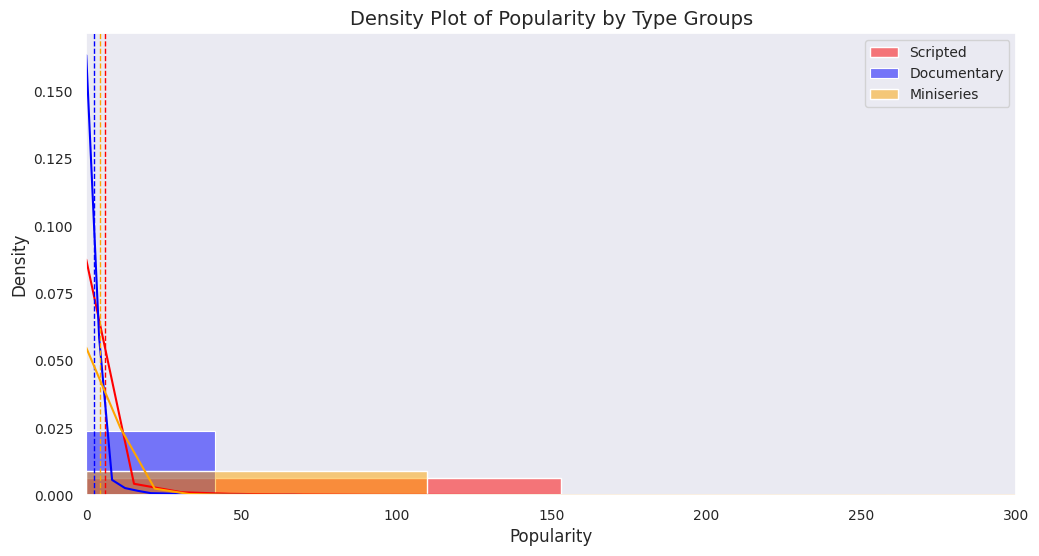

In [ ]:
# Get the top 3 most common type groups (to keep the plot readable)
top_types = filtered_df['type_group'].value_counts().head(3).index.tolist()

# Extract groups
group_data = [filtered_df[filtered_df['type_group'] == typ]['popularity'] for typ in top_types]

# Create the density plot
plt.figure(figsize=(12, 6))

colors = ['red', 'blue', 'orange']

for i, typ in enumerate(top_types):
    sns.histplot(group_data[i], kde=True, label=f'{typ.title()}', color=colors[i],
                 bins=20, stat="density", alpha=0.5)
    plt.axvline(np.mean(group_data[i]), color=colors[i], linestyle='--', linewidth=1)

# Titles and labels
plt.title('Density Plot of Popularity by Type Groups', fontsize=14)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.xlim(0, 300)

plt.show()


### ANOVA: TV Shows Genre Groups

In [ ]:
# If genre_group is already a list (from previous processing), just explode directly
genre_df = df.copy()

# Ensure all entries are lists (genre data originally contains multi value sets separated by commas)
genre_df['genre_group'] = genre_df['genre_group'].apply(
    lambda x: x if isinstance(x, list) else str(x).split(',')
)

# Explode the list into separate rows
genre_df = genre_df.explode('genre_group')

# Clean up whitespace and ensure all are strings
genre_df['genre_group'] = genre_df['genre_group'].astype(str).str.strip().str.title()

# Select top 3 most common genres (excluding 'Other')
genre_df = genre_df[genre_df['genre_group'].str.lower() != 'other']
top_genres = genre_df['genre_group'].value_counts().head(3).index.tolist()
print("Top 3 genres (excluding 'Other'):", top_genres)

filtered_genre_df = genre_df[genre_df['genre_group'].isin(top_genres)]

# Perform one-way ANOVA test
groups = [group['popularity'].values for name, group in filtered_genre_df.groupby('genre_group')]
f_stat, p_value = stats.f_oneway(*groups)

print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# ANOVA interpretation
if p_value < 0.05:
    print("✅ The differences in average popularity between genres are statistically significant.")
else:
    print("❌ No significant difference in average popularity between genres.")

Top 3 genres (excluding 'Other'): ['Drama', 'Comedy', 'Documentary']

ANOVA F-statistic: 224.6356
P-value: 4.7467e-98
✅ The differences in average popularity between genres are statistically significant.


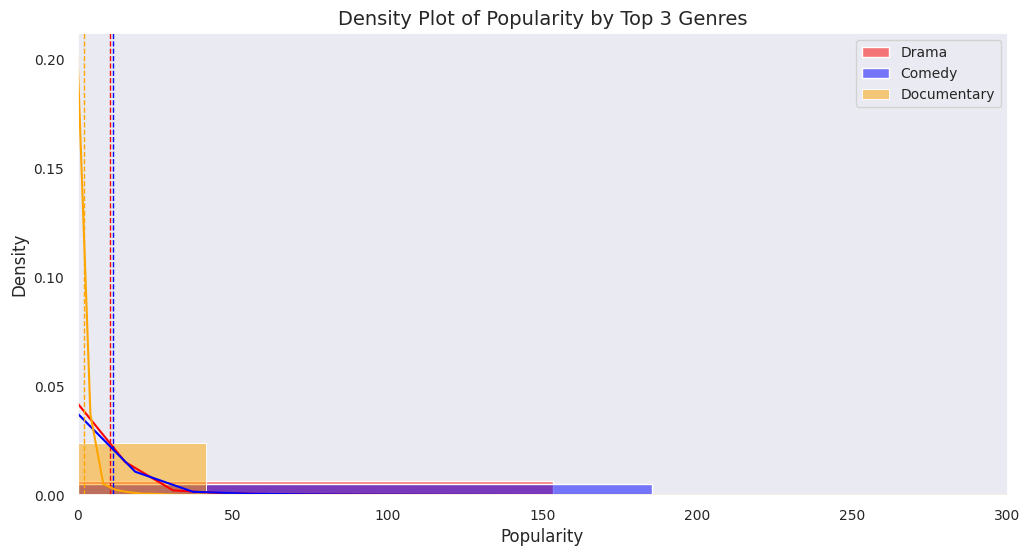

In [ ]:
# Create the density plot
plt.figure(figsize=(12, 6))
colors = ['red', 'blue', 'orange']

for i, genre in enumerate(top_genres):
    data = filtered_genre_df[filtered_genre_df['genre_group'] == genre]['popularity']
    sns.histplot(data, kde=True, label=f'{genre}', color=colors[i],
                 bins=20, stat="density", alpha=0.5)
    plt.axvline(np.mean(data), color=colors[i], linestyle='--', linewidth=1)

# Titles and labels
plt.title('Density Plot of Popularity by Top 3 Genres', fontsize=14)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.xlim(0, 300)
plt.show()



*   Our T-Tests did not manage to raise any apparent connection between the chosen binary features and the target popularity
*   On the other hand, the ANOVA tests we performed strengthens our earlier prediction that the main characteristical features (genre,type and language) have a high importance in influencing the popularity since we can clearly see the distinction between popularity levels within each categorical value



# Outliers

### Plot Boxes for Numeric Features to View Outlier Trends

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


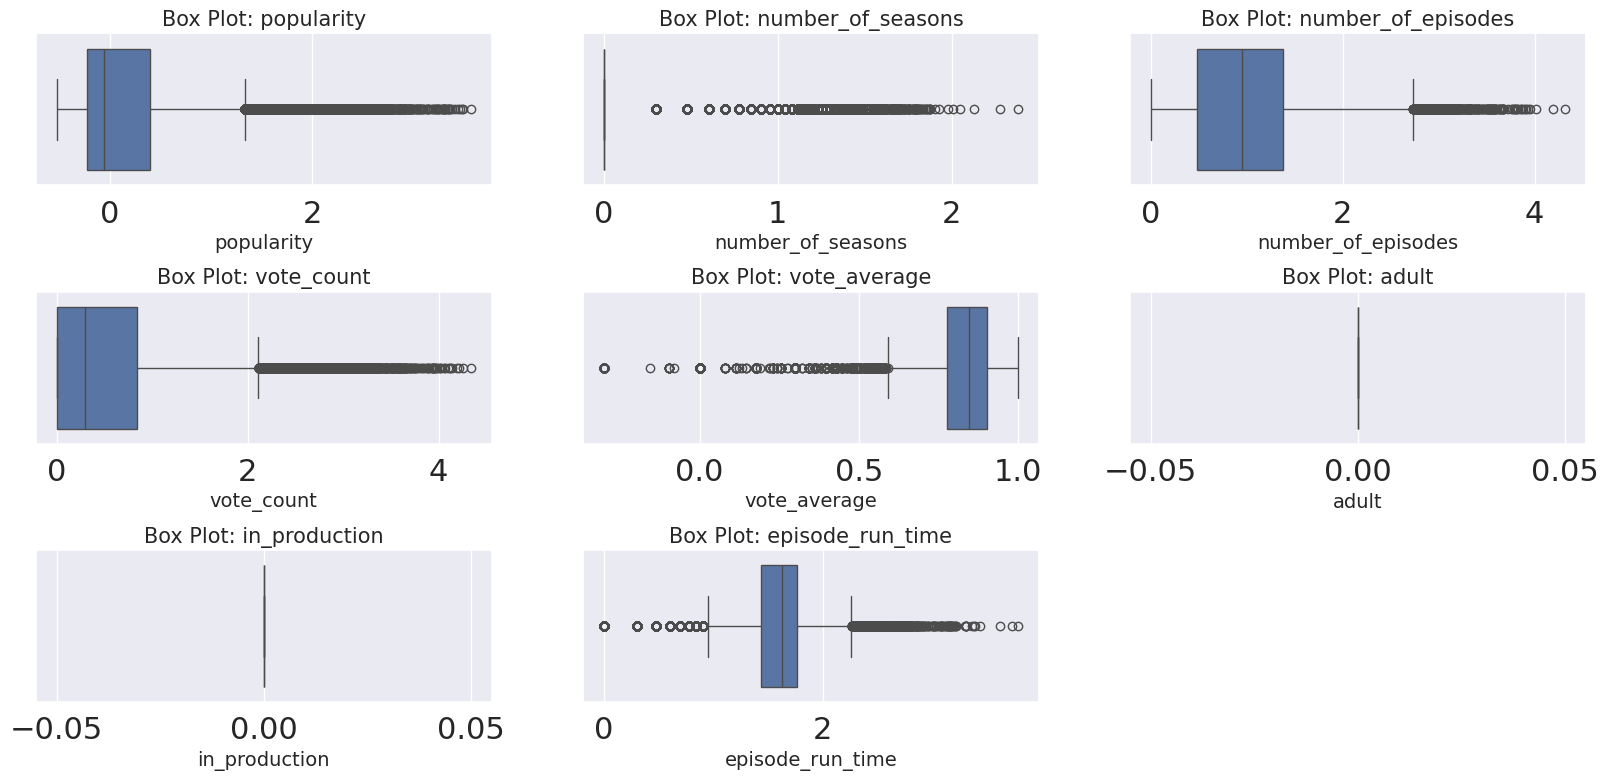

In [ ]:
# Focus on numeric features
df_continuous = df.select_dtypes(include=['float64', 'int64'])

# Exclude 'ID' column as it is not relevant for outlier treatment
df_continuous.drop(columns=['id'], inplace=True)

# Convert INT columns to float to be able to use log function
df_continuous = df_continuous.astype({col: 'float64' for col in df_continuous.select_dtypes(include='int64').columns})

# Switch to log to better identify outlier trends
df_continuous_log=np.log10(df_continuous)

# Define the function to plot box plots for each numeric column
def outliers_boxplot(df):
    plt.figure(figsize=(20, 200))
    for i, col in enumerate(df.columns):
        ax = plt.subplot(60, 3, i + 1)
        sns.boxplot(data=df, x=col, ax=ax)
        plt.title(f'Box Plot: {col}', fontsize=15)
        plt.xlabel(f'{col}', fontsize=14)
    plt.subplots_adjust(hspace=0.7)
    plt.show()

# Plot the charts
outliers_boxplot(df_continuous_log)

### Detect Outliers Using IQR

In [ ]:
from scipy.stats import ks_2samp
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# Define function for outlier detection
def detect_outliers_iqr(df):
    outliers = pd.DataFrame(index=df.index)
    for col in df.columns:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower) | (df[col] > upper)).astype(int)
    return outliers

outliers_df = detect_outliers_iqr(df_continuous_log)

# Define which outliers matter
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])

for col in outliers_df.columns:
    out = df_continuous_log[col]
    non_out = df_continuous_log[col][outliers_df[col] == 0]
    cor_out = df_continuous_log['popularity']
    cor_non_out = df_continuous_log['popularity'][outliers_df[col] == 0]

    # Validate before correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)

    # Check correlation change
    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_diff = abs(
            np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] -
            np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]
        )
        cor_change = '+' if cor_diff > 0.05 else '-'
    else:
        cor_change = '-'

    # Check distribution difference
    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    out_df.loc[len(out_df)] = {
        'feature': col,
        'outliers_cnt': outliers_df[col].sum(),
        'distribution_changed': dist_change,
        'correlation_changed': cor_change
    }

# Mark features to drop outliers from (distribution changes but correlation doesn’t)
out_df['drop'] = np.where(
    (out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'),
    'yes', 'no'
)

# Identify features to clean and put NaN instead of existing values
to_drop = out_df.loc[
    (out_df['drop'] == 'yes') & (out_df['feature'] != 'popularity') & (out_df['feature'] != 'id'),
    'feature'
].tolist()

print("Features where outliers will be replaced with NaN:")
print(to_drop)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/nu

Features where outliers will be replaced with NaN:
['number_of_seasons', 'number_of_episodes']


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


### Replace Outliers with NaN (Cell-Wise)

In [ ]:
df_cleaned = df.copy()

for col in to_drop:
    df_cleaned.loc[outliers_df[col] == 1, col] = np.nan
    if col in df_continuous_log.columns:
        df_continuous_log.loc[outliers_df[col] == 1, col] = np.nan

# Check new missing values
null_summary = df_cleaned[to_drop].isna().sum().sort_values(ascending=False)
print("\n🧩 Newly created (or existing) missing values after outlier removal:")
print(null_summary)


🧩 Newly created (or existing) missing values after outlier removal:
number_of_seasons     54238
number_of_episodes    24109
dtype: int64


### Impute Missing Numeric Values Using MICE

In [ ]:
df_final = df_cleaned.copy()
imp_cols = df_final.select_dtypes(include=['float64','int64']).columns

imputer = IterativeImputer(max_iter=10, random_state=42, min_value=0)
df_final[imp_cols] = imputer.fit_transform(df_final[imp_cols])

# optional safety: clip in case of tiny numerical drift
df_final[imp_cols] = df_final[imp_cols].clip(lower=0)

### Summary of Outlier Treatment

In [ ]:
# Ensure that imputation was successful by checking no. of remaining missing values
continuous_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("\n✅ Remaining missing values after MICE imputation:")
print(df_final[continuous_cols].isna().sum())

# Inspect how many values were changed during imputation
num_changed = (df[continuous_cols] != df_final[continuous_cols]).sum()
print("\n🔍 Number of changed values per column (due to outlier cleaning + imputation):")
print(num_changed)


✅ Remaining missing values after MICE imputation:
id                    0
popularity            0
number_of_seasons     0
number_of_episodes    0
vote_count            0
vote_average          0
adult                 0
in_production         0
episode_run_time      0
dtype: int64

🔍 Number of changed values per column (due to outlier cleaning + imputation):
id                        0
popularity                0
number_of_seasons     54238
number_of_episodes    24100
vote_count                0
vote_average              0
adult                     0
in_production             0
episode_run_time          0
dtype: int64


Summary of outlier treatment using MICE:


*   About 54K values of 'number of season' feature were replaced
*   About 24K values of 'number of episodes' feature were replaced



In [ ]:
# re-assing df
df = df_final.copy()

# Feature Engineering

### Feature Enrichment

Date-Based Features

In [ ]:
# I will use the 2 date fields to calculate the tenure of each show and the year the show debuted
# Create 'show_begin_year' (year of first_air_date, 0 if missing)
df['show_begin_year'] = df['first_air_date'].dt.year.fillna(0).astype(int)

# Create 'show_tenure_years' (difference in years, 0 if missing)
df['show_tenure_years'] = (
    (df['last_air_date'] - df['first_air_date'])
    .dt.days
    .div(365.25)
    .fillna(0)
    .clip(lower=0)
    .astype(float)
)

# Calculate a measure of average seasons per show year - a 'productive' show may be an indication of a successul one
df['avg_seasons_year'] = df.apply(
    lambda row: 0 if row['show_begin_year'] == 0 or pd.isna(row['show_begin_year'])
    else row['number_of_seasons'] / row['show_begin_year'],
    axis=1
)

# Drop helper columns
df.drop(columns=['first_air_date', 'last_air_date'], inplace=True)

Numerical Features

In [ ]:
# Some tv shows have '0' as number of seasons. since every show has at least one season, I will update those values to '1'
df['number_of_seasons'] = df['number_of_seasons'].replace(0, 1)

# This column represents number of available languages per show. I will use it to calculate how many languages are available per show (as a number)
df['num_languages'] = df['languages'].apply(
    lambda x: len([lang.strip() for lang in x.split(',')]) if pd.notna(x) and x.strip() != '' else 0
)

# Calculate a measure of average episodes per season - an average season's length may influence popularity
df['avg_episodes_per_season'] = df.apply(
    lambda row: 0 if row['number_of_seasons'] == 0 or pd.isna(row['number_of_seasons'])
    else row['number_of_episodes'] / row['number_of_seasons'],
    axis=1
)

Categorical Features

In [ ]:
# Based on the 'languages' column which lists available languages for a show, calculate if a show is available in languages other than English

# Ensure the column is string and handle NaN values safely
df['languages'] = df['languages'].fillna('').astype(str)

# Create a binary flag for whether there is *any* non-English language
df['has_non_english_language'] = df['languages'].apply(
    lambda x: any(lang.strip().lower() != 'en' for lang in x.split(',') if lang.strip())
).astype(int)

# I will also create a calculated column based on 'origin country' to check if a show's origin is from multiple countries
df['multi_origin_country'] = (
    df['origin_country']
    .astype(str)
    .replace('nan', '')
    .apply(lambda x: len([c for c in x.split(',') if c.strip()]) > 1)
    .astype(int)
)

# Drop helper columns
df.drop(columns=['languages','origin_country'], inplace=True)

### Feature Transformation

Fill Ramaining Categories with NaN Values with 'Other'

In [ ]:
# Replace NaN, 'nan', or empty strings with 'other'
df[['overview', 'networks']] = (
    df[['overview', 'networks']]
    .replace(['nan', 'NaN', ''], np.nan)
    .fillna('other')
)

Apply 'One-Hot' Encoding for Selected Categorical Columns

In [ ]:
# Define a function to create dummies based on given categorical groups (returns one-hot encoded columns)
def one_hot_encode(df, columns, drop_first=True):

    for col in columns:
        # Create one-hot encoded columns
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=drop_first)
        # Make column names lowercase
        dummies.columns = [c.lower() for c in dummies.columns]
        # Merge back into df
        df = pd.concat([df.drop(columns=[col]), dummies], axis=1)
    return df

# Apply function on categories which have only one value per row
categorical_columns = ['language_group', 'type_group', 'status']
df = one_hot_encode(df, categorical_columns)

Apply 'Multi-Hot' Encoding for Selected Categorical Columns

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Define a function to return a dataFrame with multi-hot encoded columns
def multi_hot_encode(df, columns, prefixes=None, drop_original=True):

    if prefixes is None:
        prefixes = columns

    for col, prefix in zip(columns, prefixes):
        mlb = MultiLabelBinarizer()
        encoded = pd.DataFrame(
            mlb.fit_transform(df[col]),
            columns=[f"{prefix}_{c}".lower() for c in mlb.classes_],
            index=df.index
        )
        if drop_original:
            df = pd.concat([df.drop(columns=[col]), encoded], axis=1)
        else:
            df = pd.concat([df, encoded], axis=1)

    return df

# Apply function on categories which more than one value per row (separated by a comma)
multi_hot_columns = ['country_group', 'genre_group']
df = multi_hot_encode(df, multi_hot_columns)

Handle the 'Networks' Category - Apply 'Multi-Hot' & Frequency Encoding



*   The 'network' category has 2 main setbacks: values are separated by a comma, and there are many possible values of networks
*   I will combine 2 approaches: multi-hot encoding for the top 10 networks (according to their count), and frequency encoding that will add a column of relative frequency
* This way I will be able to answer 2 questions: "Does this show belong to a major network?" (multi-hot) / "How globally frequent is this network?" (frequency encoding)



In [ ]:
# Rename NaN's as 'other'. we will later exclude it
df['networks'] = df['networks'].fillna('other')

# Prepare network list of possible values, replace NaN/empty with 'Other'
df['network_list'] = df['networks'].astype(str).apply(
    lambda x: [n if n and n.lower() != 'nan' else 'other' for n in x.split(', ')]
)

# Flatten all networks and get their frequencies
all_networks = [net for nets in df['network_list'] for net in nets]
network_counts = pd.Series(all_networks).value_counts()

# Relative frequency mapping: use relative frequency (proportion of dataset)
network_freq_map = (network_counts / len(df)).to_dict()

# Add frequency column as the average of all networks in the row
df['network_frequency'] = df['network_list'].apply(
    lambda nets: np.mean([network_freq_map.get(n, 0) for n in nets]) if nets else 0
)

# Multi-hot encoding for top-10 networks (exclude 'Other')
TOP_N = 11
top_networks = [net for net in network_counts.head(TOP_N).index if net != 'other']

for net in top_networks:
    col_name = f'network_{net.replace(" ", "_").lower()}'
    df[col_name] = df['network_list'].apply(lambda nets: int(net in nets))

# Drop helper column
df = df.drop(columns=['network_list','networks'])

### Feature Selection

Split to X (categories) and y (target value)

In [ ]:
# Leave out target value and fields we will not need anymore for regressions
X = df.drop(columns=['id','name','popularity','vote_count','vote_average','overview'])
y = df['popularity']

Perform Feature Importance Tests Using Lasso / Ridge

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVR

# Lasso (L1) and Ridge (L2)
lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

ridge = Ridge(alpha=0.01).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

# Linear SVR (regression version of SVC)
svr = LinearSVR(C=0.01).fit(X, y)
svr_selected = (np.abs(svr.coef_[0]) > 0).astype(int)

# Gradient Boosting and Random Forest (regressors)
gb = GradientBoostingRegressor().fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

rf = RandomForestRegressor().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Combine results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected,
    'SVR': svr_selected,
    'GradientBoost': gb_selected,
    'RandomForest': rf_selected,
    'Ridge': ridge_selected
})

selection_df['Sum'] = selection_df[['Lasso', 'SVR', 'GradientBoost', 'RandomForest', 'Ridge']].sum(axis=1)
print(selection_df)


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                            Feature  Lasso  SVR  GradientBoost  RandomForest  \
0                 number_of_seasons      0    1              0             0   
1                number_of_episodes      1    1              1             1   
2                             adult      0    1              0             1   
3                     in_production      1    1              1             1   
4                  episode_run_time      1    1              1             1   
5                   show_begin_year      1    1              1             1   
6                 show_tenure_years      1    1              1             1   
7                  avg_seasons_year      0    1              1             1   
8                     num_languages      1    1              1             1   
9           avg_episodes_per_season      1    1              1             1   
10         has_non_english_language      1    1              1             1   
11             multi_origin_country     

Create a New DF Using Important Features Only

In [ ]:
# Choose variables with a sum of selections >= 4 only
final_var = selection_df[selection_df['Sum'] >= 4]['Feature'].tolist()
df_model = df[final_var].copy()

# Add back y target to new df
df_model['popularity'] = df['popularity'].copy()

# Output the results
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164705 entries, 0 to 164704
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   number_of_episodes               164705 non-null  float64
 1   in_production                    164705 non-null  float64
 2   episode_run_time                 164705 non-null  float64
 3   show_begin_year                  164705 non-null  int64  
 4   show_tenure_years                164705 non-null  float64
 5   avg_seasons_year                 164705 non-null  float64
 6   num_languages                    164705 non-null  int64  
 7   avg_episodes_per_season          164705 non-null  float64
 8   has_non_english_language         164705 non-null  int64  
 9   language_group_english           164705 non-null  bool   
 10  language_group_middle_eastern    164705 non-null  bool   
 11  language_group_other             164705 non-null  bool   
 12  la

# Model Selection

### Split Data to X & y , Train Dev & Test

In [ ]:
from sklearn.model_selection import train_test_split

# Define the target and feature set
X = df_model.drop(columns=['popularity'])
y = df_model['popularity']

# Total number of samples
total_samples = len(df_model)

# First split: training and temporary (test + dev)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: testing and development (dev)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Calculate percentages
train_percent = (X_train.shape[0] / total_samples) * 100
dev_percent = (X_dev.shape[0] / total_samples) * 100
test_percent = (X_test.shape[0] / total_samples) * 100

# Output the sizes of each set in percentages
print(f"Training set size: {train_percent:.2f}%")
print(f"Validation (Dev) set size: {dev_percent:.2f}%")
print(f"Testing set size: {test_percent:.2f}%")


Training set size: 70.00%
Validation (Dev) set size: 15.00%
Testing set size: 15.00%


### Run a Baseline Basic Regression Model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [ ]:
# Compute RMSLE safely (clip negatives to zero)
def safe_rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except ValueError:
        return np.nan

# Run baseline model using a simple LinearRegression()
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_dev)

baseline_mse = mean_squared_error(y_dev, y_pred_baseline)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_dev, y_pred_baseline)
baseline_rmsle = safe_rmsle(y_dev, y_pred_baseline)
baseline_r2 = r2_score(y_dev, y_pred_baseline)

print("📊 Baseline (Linear Regression) Performance:")
print(f"MSE:   {baseline_mse:.4f}")
print(f"RMSE:  {baseline_rmse:.4f}")
print(f"MAE:   {baseline_mae:.4f}")
print(f"RMSLE: {baseline_rmsle:.4f}")
print(f"R²:    {baseline_r2:.4f}\n")

📊 Baseline (Linear Regression) Performance:
MSE:   1577.2060
RMSE:  39.7141
MAE:   7.8955
RMSLE: 1.0014
R²:    0.1494





*   A basic regression model using LinearRegression() results in a very limited ability to predict popularity with the data available (R Square = 15%)




### Run Additional Regression Models and Compare to Baseline

🔹 Training Ridge...
🔹 Training Lasso...
🔹 Training ElasticNet...
🔹 Training KNN...
🔹 Training SVR...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


🔹 Training Decision Tree...
🔹 Training Random Forest...
🔹 Training Gradient Boosting...
🔹 Training AdaBoost...
🔹 Training XGBoost...

🏁 Model Comparison Results (Development Set):


,Model,MSE,RMSE,MAE,RMSLE,R²
0,Baseline (LinearRegression),1577.205971,39.714053,7.895523,1.001409,0.149380
1,Random Forest,1376.569234,37.102146,5.508384,0.629545,0.257588
2,Gradient Boosting,1465.131820,38.277040,6.029162,0.787003,0.209824
3,XGBoost,1479.983255,38.470550,5.696448,0.695421,0.201814
4,Ridge,1578.420470,39.729340,7.857654,0.998191,0.148725
5,ElasticNet,1604.413658,40.055133,6.790128,0.894153,0.134706
6,Lasso,1606.606056,40.082491,6.841090,0.902823,0.133524
7,SVR,1763.524032,41.994333,5.855007,0.825797,0.048895
8,KNN,1867.563871,43.215320,6.413455,0.719981,-0.007216
9,Decision Tree,2114.919173,45.988250,6.475391,0.736022,-0.140620


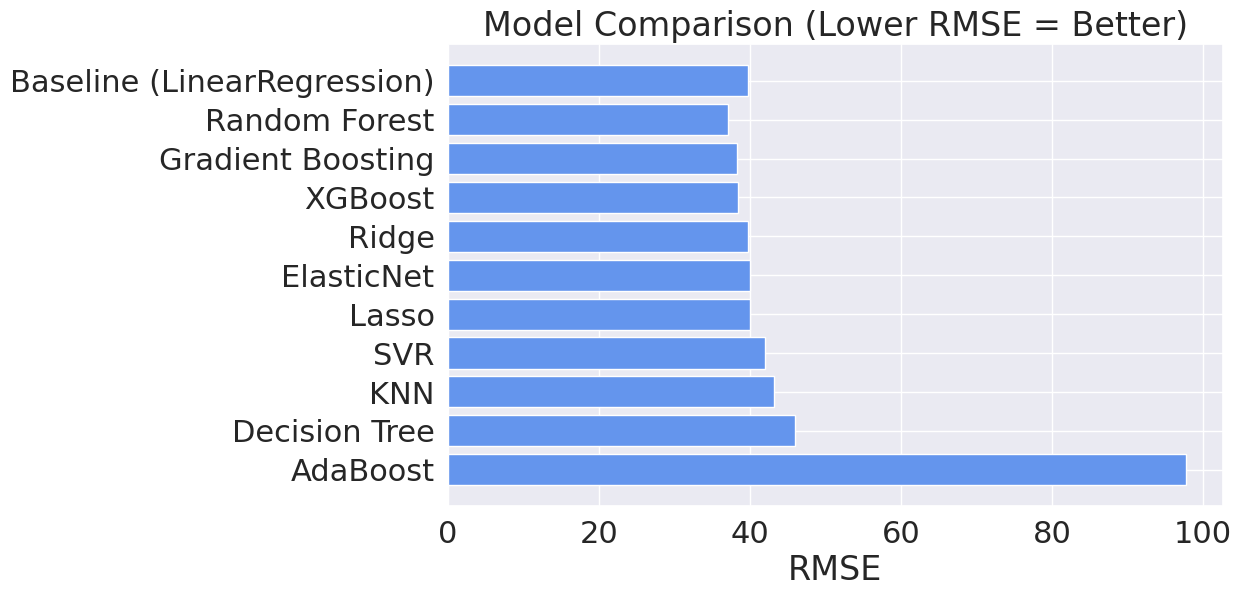

In [ ]:
# Define regression models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'KNN': KNeighborsRegressor(),
    'SVR': LinearSVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Train and evaluate models
results = []

for name, model in models.items():
    print(f"🔹 Training {name}...")
    model.fit(X_train, y_train)
    y_pred_dev = model.predict(X_dev)

    mse = mean_squared_error(y_dev, y_pred_dev)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_dev, y_pred_dev)
    rmsle = safe_rmsle(y_dev, y_pred_dev)
    r2 = r2_score(y_dev, y_pred_dev)

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'RMSLE': rmsle,
        'R²': r2
    })
# Summarize model comparison
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)

# Add baseline model
baseline_row = pd.DataFrame([{
    'Model': 'Baseline (LinearRegression)',
    'MSE': baseline_mse,
    'RMSE': baseline_rmse,
    'MAE': baseline_mae,
    'RMSLE': baseline_rmsle,
    'R²': baseline_r2
}])

results_df = pd.concat([baseline_row, results_df], ignore_index=True)

print("\n🏁 Model Comparison Results (Development Set):")
display(results_df)

# Plot comparison summary
plt.figure(figsize=(10,6))
plt.barh(results_df['Model'], results_df['RMSE'], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title('Model Comparison (Lower RMSE = Better)')
plt.xlabel('RMSE')
plt.show()



*   Our chosen regression model after model comparison: Random Forrest regressor
*   It presents the relatively highest R-square and lowest RMSE measures



# Fine-Tuning of Selected Regression Model - Random Forrest Regressor

### Set Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd

# Compute RMSLE safely (avoiding negatives and NaNs)
def safe_rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Evaluate a model on test data using multiple metrics
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    rmsle = safe_rmsle(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'RMSLE': rmsle, 'R²': r2}

# Set parameter grids
# Random Search (wide exploration)
rf_random_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Grid Search (fine-tuning)
rf_grid_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

### Randomized Search

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_random_params,
    n_iter=20,  # reduce to run faster
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("🔎 Running RandomizedSearchCV for Random Forest...")
rf_random_search.fit(X_train, y_train)
print(f"✅ Best params (Random Search): {rf_random_search.best_params_}")

🔎 Running RandomizedSearchCV for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best params (Random Search): {'bootstrap': False, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 223}


### Grid Search

In [ ]:
rf_best_random = rf_random_search.best_estimator_

rf_grid_search = GridSearchCV(
    estimator=rf_best_random,
    param_grid=rf_grid_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("⚙️ Running GridSearchCV for fine-tuning...")
rf_grid_search.fit(X_train, y_train)
print(f"✅ Best params (Grid Search): {rf_grid_search.best_params_}")

⚙️ Running GridSearchCV for fine-tuning...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
✅ Best params (Grid Search): {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


### Evaluate Final Tuned Model

In [ ]:
rf_best = rf_grid_search.best_estimator_

# Evaluate tuned model
rf_tuned_results = evaluate_model("Random Forest (Tuned)", rf_best, X_test, y_test)
rf_tuned_results = pd.DataFrame([rf_tuned_results])

# Get baseline from earlier results_df
baseline_rf = results_df[results_df['Model'] == 'Random Forest'].iloc[0]

### Compare with Baseline

In [ ]:
comparison = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'RMSLE', 'R²'],
    'Baseline': [
        baseline_rf['MSE'], baseline_rf['RMSE'], baseline_rf['MAE'],
        baseline_rf['RMSLE'], baseline_rf['R²']
    ],
    'Tuned': [
        rf_tuned_results['MSE'][0], rf_tuned_results['RMSE'][0],
        rf_tuned_results['MAE'][0], rf_tuned_results['RMSLE'][0],
        rf_tuned_results['R²'][0]
    ]
})

# Compute % improvement (positive = better, negative = worse)
for col in ['MSE', 'RMSE', 'MAE', 'RMSLE']:
    baseline_val = comparison.loc[comparison['Metric'] == col, 'Baseline'].values[0]
    tuned_val = comparison.loc[comparison['Metric'] == col, 'Tuned'].values[0]
    comparison.loc[comparison['Metric'] == col, 'Improvement_%'] = (
        (baseline_val - tuned_val) / baseline_val * 100
    )

# For R², higher is better (reverse logic)
baseline_r2 = comparison.loc[comparison['Metric'] == 'R²', 'Baseline'].values[0]
tuned_r2 = comparison.loc[comparison['Metric'] == 'R²', 'Tuned'].values[0]
comparison.loc[comparison['Metric'] == 'R²', 'Improvement_%'] = (
    (tuned_r2 - baseline_r2) / abs(baseline_r2) * 100
)

# Add note for clarity
comparison['Interpretation'] = comparison['Improvement_%'].apply(
    lambda x: '✅ Improvement' if x > 0 else '❌ Worse'
)

print("\n📊 Comparison: Baseline vs. Tuned Random Forest")
print(comparison.round(4))


📊 Comparison: Baseline vs. Tuned Random Forest
  Metric   Baseline      Tuned  Improvement_% Interpretation
0    MSE  1376.5692  1216.6131        11.6199  ✅ Improvement
1   RMSE    37.1021    34.8800         5.9893  ✅ Improvement
2    MAE     5.5084     4.6129        16.2574  ✅ Improvement
3  RMSLE     0.6295     0.6153         2.2681  ✅ Improvement
4     R²     0.2576     0.3091        20.0055  ✅ Improvement


To Summarize:

*   Unfortunately we have not managed to find an alternative regression model which results in a significantly higher R-Square and/or significantly lower RMSE, compared to the basic LinearRegression model
*   We did, however, manage to improve the performance of the Random Forrest Regressor model by fine-tuning (a 20% improvement in R-square)
*   A less-skewed data might have resulted in a better fitting of one or more of the regression models
*   It is also possible that the high percentage of missing values for key features such as show genre and show overview (even after we managed to restore some of them using the API's) contributed to the challenge of predicting tv shows popularity with TMDB data



